In [1]:
!pip -q install scikit-learn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print("TF:", tf.__version__)

TF: 2.19.0


In [2]:
def synthetic_function_np(X: np.ndarray) -> np.ndarray:
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]
    y = np.sin(x1) + 0.3*(x2**2) - np.exp(-x3) + 0.1*x1*x2*x3
    return y.reshape(-1, 1)

def make_dataset(n=6000, seed=1, noise_std=0.05):
    rng = np.random.default_rng(seed)
    x1 = rng.uniform(-3.0, 3.0, size=(n, 1))
    x2 = rng.uniform(-2.0, 2.0, size=(n, 1))
    x3 = rng.uniform(0.0, 4.0, size=(n, 1))
    X = np.concatenate([x1, x2, x3], axis=1)
    y = synthetic_function_np(X)
    y = y + rng.normal(0.0, noise_std, size=y.shape)
    return X.astype(np.float32), y.astype(np.float32)

def standardize_train_test(X, y, test_frac=0.2, seed=2):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = rng.permutation(n)
    n_test = int(n * test_frac)
    test_idx, train_idx = idx[:n_test], idx[n_test:]

    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    X_mean, X_std = Xtr.mean(0, keepdims=True), Xtr.std(0, keepdims=True) + 1e-8
    y_mean, y_std = ytr.mean(0, keepdims=True), ytr.std(0, keepdims=True) + 1e-8

    Xtr = (Xtr - X_mean) / X_std
    Xte = (Xte - X_mean) / X_std
    ytr = (ytr - y_mean) / y_std
    yte = (yte - y_mean) / y_std

    norms = dict(X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std)
    return Xtr, ytr, Xte, yte, norms

In [3]:
def plot_parity(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure()
    plt.scatter(y_true.flatten(), y_pred.flatten(), s=8, alpha=0.6)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

In [4]:
X, y = make_dataset(n=6000, seed=1, noise_std=0.05)
Xtr, ytr, Xte, yte, norms = standardize_train_test(X, y, test_frac=0.2, seed=2)

In [5]:
class SubclassMLP(tf.keras.Model):
    def __init__(self, h1=64, h2=64):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(h1, activation="tanh")
        self.d2 = tf.keras.layers.Dense(h2, activation="tanh")
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.out(x)

model = SubclassMLP()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model.build(input_shape=(None, 3))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'subclass_mlp', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "subclass_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

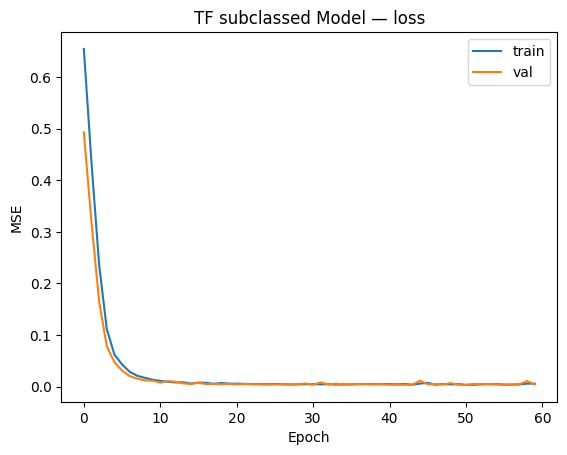

In [6]:
hist = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=60, batch_size=256, verbose=0)
plt.figure()
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("TF subclassed Model — loss")
plt.legend()
plt.show()


Test MSE (denormalized): 0.003840105142444372


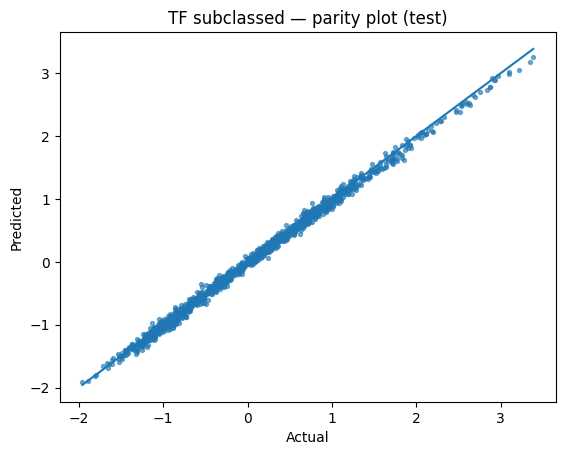

In [7]:
yhat_te = model.predict(Xte, verbose=0)
yhat_te_den = yhat_te * norms["y_std"] + norms["y_mean"]
yte_den = yte * norms["y_std"] + norms["y_mean"]
test_mse = np.mean((yhat_te_den - yte_den)**2)
print("Test MSE (denormalized):", float(test_mse))
plot_parity(yte_den, yhat_te_den, title="TF subclassed — parity plot (test)")